In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch, torchvision
import torchvision.transforms as transforms

### Make sure your runtime type is either GPU or TPU

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:55<00:00, 3069555.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The list of class names in the dataset

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([128, 3, 32, 32]) torch.Size([128])
automobile


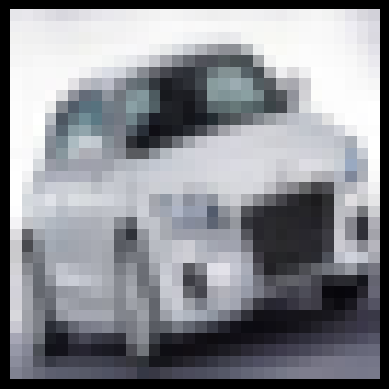

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size(), labels.size())

i = 12
imshow(images[i].permute([1, 2, 0]).numpy()/2 + .5)
axis('off')
print(classes[labels[i].item()])



---



## Task 1
Build a neural network with two *Linear* layers and an output layer. The first Linear layer should have 512 neurons and the second 128 neurons. Both layers should use *relu* activation function. After each of these *Linear* layers, you should have a *dropout* layer (torch.nn.Dropout) with dropout probability 0.2. The output layer
should be a *Linear* layer.

Use torch.nn.CrossEntropyLoss to compute the loss value of the model output. Use *adam* optimizer to update the model parameters when training the model.

In [25]:

class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(32*32*3, 512)  
        self.dropout1 = torch.nn.Dropout(0.2)    
        self.fc2 = torch.nn.Linear(512, 128)     
        self.dropout2 = torch.nn.Dropout(0.2)    
        self.fc3 = torch.nn.Linear(128, 10)      

    def forward(self, x):
        x = self.flatten(x)        
        x = torch.nn.functional.relu(self.fc1(x))    
        x = self.dropout1(x)       
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)     
        return x

nn = NeuralNet()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn.parameters(), lr=0.001)

## Task 2
Train the model for 50 epochs. Evaluate the model on the testing data. Print out the model accuracy on test data after the training.

In [26]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

correct = 0
total = 0
with torch.no_grad():

    for data in testloader:
        images, labels = data
        outputs = nn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy = {100 * (correct/total)}%')

Accuracy = 50.9%


## Task 3
Implement a function *recognize*. It takes an image (shape = 3, 32, 32) as an input and use the "model" you trained above to make a prediction of the image's class. Your function should return the predicted (string) class (use the classes list above to map numeric prediction to string label).

Neural network recognizes this image as: cat
true image label: cat


(-0.5, 31.5, 31.5, -0.5)

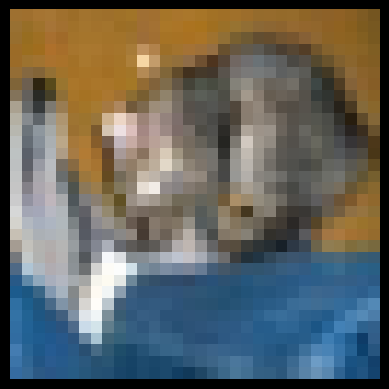

In [19]:
def recognize(new_img):
    new_img = new_img.unsqueeze(0)
    output = nn(new_img)
    _, predicted = torch.max(output, 1)
    predicted_class = classes[predicted.item()]
    return predicted_class

dataiter = iter(testloader)
images, labels = next(dataiter)
new_img = images[0]
nn.to('cpu')
pred = recognize(new_img)

print('Neural network recognizes this image as:', pred)
print('true image label:', classes[labels[0].item()])
imshow(new_img.permute([1, 2, 0]).numpy()/2 + .5)
axis('off')

### Task 4

Implement a CNN with the following structure:
- 4 Conv layers:  
(3x3)x32, (3x3)x32, (3x3)x64, (3x3)x64

- 2x2 Maxpool after 2nd and 4th conv.
- Dropout after pooling
- One FC layer and then a FC output layer

Train the CNN model until training accuracy converges.
(Compute accuracy on training data at the end of each epoch. Plot the accuracy values vs epochs to determine whether it converges.) Test the accuracy of the trained model on the testing dataset.

In [22]:

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = torch.nn.Dropout(0.25)

        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = torch.nn.Dropout(0.25)

        self.fc1 = torch.nn.Linear(64 * 8 * 8, 512)
        self.fc2 = torch.nn.Linear(512, 10) 

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = torch.nn.functional.relu(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(-1, 64 * 8 * 8)  
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn = CNN()
cnn.to('cpu')


optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

Epoch 1, Accuracy: 46.3%
Epoch 2, Accuracy: 62.392%
Epoch 3, Accuracy: 69.838%
Epoch 4, Accuracy: 75.186%
Epoch 5, Accuracy: 78.602%
Epoch 6, Accuracy: 82.082%
Epoch 7, Accuracy: 85.116%
Epoch 8, Accuracy: 87.724%
Epoch 9, Accuracy: 89.718%
Epoch 10, Accuracy: 91.184%
Epoch 11, Accuracy: 92.86%
Epoch 12, Accuracy: 93.632%
Epoch 13, Accuracy: 94.642%
Epoch 14, Accuracy: 95.056%
Epoch 15, Accuracy: 95.354%
Epoch 16, Accuracy: 95.784%
Epoch 17, Accuracy: 96.05%
Epoch 18, Accuracy: 96.348%
Epoch 19, Accuracy: 96.402%
Epoch 20, Accuracy: 96.588%


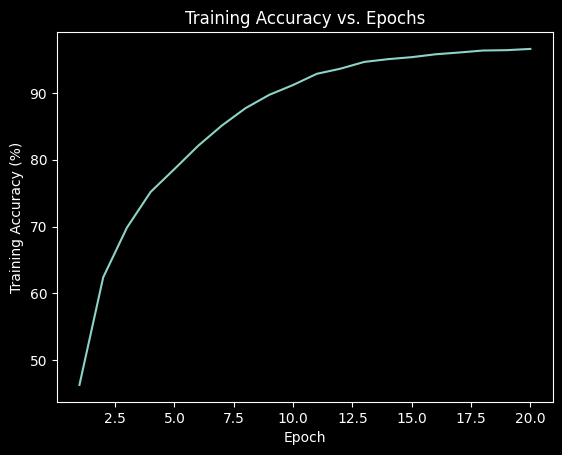

In [23]:
import matplotlib.pyplot as plt

epochs = 20
train_accuracy = []

for epoch in range(epochs):
    correct = 0
    total = 0
    for data in trainloader:
        inputs, labels = data[0].to('cpu'), data[1].to('cpu')
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_accuracy.append(accuracy)
    print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')


plt.plot(range(1, epochs+1), train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy vs. Epochs')
plt.show()

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to('cpu'), data[1].to('cpu')
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy = {100 * (correct/total)}%')

Accuracy = 73.68%
